# Final project for the Capstone course

## Introduction:
The city of Regensburg is a small, academic, medieval, and historic city, due to this not only the tourism around it but the flow of students, in times without the pandemic, are constant. The city is structured into seven districts, some more oriented for academic purposes and some for tourism. 
The problem to address in this notebook is:
Which district has the best Cofé shop and which one is the best to open a Cofé shop, this taking into account the distribution of the current Cofé shops around the city and the number of clients using the tips.

## Data: 
### Sources:
The data has been taken from different places according its type:

1. For the Postal code and the districts of the city of Regensburg:
the Deutsche Post website: https://www.postdirekt.de/plzserver/PlzSearchServlet.

There one can obtain the Postal code for the six districts and for all the streets on the city. For example:

| Postal Code | City | District | Street | 
|-------------|------|----------|--------|
|93051	| Regensburg | Großprüfening-Dechbetten-Königswiesen | An der Brunnstube|

2. For the latitude and longitude we used the location data platforms :
    * Foursquare: https://foursquare.com/
    * Strassenkatalog: https://www.strassenkatalog.de
    
### Description:
 | column name | Type    | Description            |
 |-------------|---------|------------------------|
 | PostalCode  | int64   | District's postal code |
 | City        | object  | City's name            |
 | District    | object  | District's name        |
 | Latitude    | float64 | District's latitude    | 
 | Longitude   | float64 | District's longitude   |

## Metodology:
The methodology to solve the problem will be:
- Determine the six districts in a City map using its Postal Code, latitude, and longitude. 
- Determine the flow of people for each district, this finding the number of Cofé shops on each district and its number of tips using the Foursquare API.
- Find the distribution of the Cofé shops around the districts on a City map.
- Determine the best district for the new cofé shop using the distribution of the Cofé shop and its number of tips.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

from IPython.display import display

print('Libraries imported.')

Libraries imported.


### Creating the Dataframe using the csv file.

In [2]:
# Reading the file and creating the dataframe
df_r = pd.read_csv('/home/hector/Dropbox/courses/data-sci/08-App-ds-caps/regens.csv')
df_r

,PostalCode,City,District,Latitude,Longitude
0,93051,Regensburg,Großprüfening-Dechbetten-Königswiesen,49.007839,12.077042
1,93047,Regensburg,Innenstadt,49.016491,12.100904
2,93053,Regensburg,Kasernenviertel,49.012688,12.105520
3,93055,Regensburg,Ostenviertel,49.016174,12.107655
4,93049,Regensburg,Westenviertel,49.012512,12.066780
5,93055,Regensburg,Brandlberg-Keilberg,49.040813,12.152743
6,93053,Regensburg,Galgenberg,48.993454,12.110230


In [3]:
# Checking the type for each column 
df_r.dtypes

PostalCode      int64
City           object
District       object
Latitude      float64
Longitude     float64
dtype: object

## Defining important functions

In [4]:
# Funtion to get all the venues in the city 
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Obtaining all the venues in Regesnburg

In [5]:
# @hidden_cell
CLIENT_ID = '5YMOYTKQ5D5UA5ZLLUZEQL4GTTVOBZOJTDUPJJCQ1ISVEGJL' # your Foursquare ID
CLIENT_SECRET = 'N0231QPA5OQT3V5KCP1S1K4NDIORUFLCSZXAYJOAWE51PVZX' # your Foursquare Secret
ACCESS_TOKEN = 'DIMOB4IDVP1HC1NZOFISJN5FS1IS4AKDVSEKRRWB3FMDWTTP' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5YMOYTKQ5D5UA5ZLLUZEQL4GTTVOBZOJTDUPJJCQ1ISVEGJL
CLIENT_SECRET:N0231QPA5OQT3V5KCP1S1K4NDIORUFLCSZXAYJOAWE51PVZX


## Now we will filter the venues by Cofé shops 

Obtaining the coordinates for the districts in the city of Regensburg. First, we use the Foursquare API to obtain the latitude and the longitude for the city and the its districts. The we create a City map 
with all the districts on it.

In [7]:
address = 'Regensburg, DE'

geolocator = Nominatim(user_agent="reg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Regensburg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Regensburg are 49.0195333, 12.0974869.


In [8]:
#create map of Regensburg using latitude and longitude values
map_regens = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(df_r['Latitude'], df_r['Longitude'], df_r['District']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_regens)  
    
map_regens


Here we define the query for our search. In this case we selected Café, this because we want to find all the Café shops in the city. Also, we take a radius of 500 m, this because is approximately the distance for the radius of the kaser city district.

In [9]:
search_query = 'Café'
radius = 500
print(search_query + ' .... OK!')

Café .... OK!


Defining an important function to filter the categories

# Café: Großprüfening-Dechbetten-Königswiesen

In [8]:
latitude_grode =df_r.iloc[0,3]
longitude_grode =df_r.iloc[0,4]

url_grode = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_grode, longitude_grode,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_grode
results_grode = requests.get(url_grode).json()
#print(results_grode)

# assign relevant part of JSON to venues
venues_grode = results_grode['response']['venues']
#print(venues_grode) 
# tranform venues into a dataframe
df_grode = json_normalize(venues_grode)


if df_grode.shape[0] > 0:
    print('There are {} Cofe shops in the district {}.'.format(df_grode.shape[0],df_r.iloc[0,2]))
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns_grode = ['name', 'categories'] + [col for col in df_grode.columns if col.startswith('location.')] + ['id']
    df_grode_filtered = df_grode.loc[:, filtered_columns_grode]

    # filter the category for each row
    df_grode_filtered['categories'] = df_grode_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_grode_filtered.columns = [column.split('.')[-1] for column in df_grode_filtered.columns]
    display(df_grode_filtered.head(5))

else:
    print("There are NO Cofé shops in this district:", df_r.iloc[0,2] )



There are NO Cofé shops in this district: Großprüfening-Dechbetten-Königswiesen


# Café: Innerstadt 

In [10]:
latitude_inn =df_r.iloc[1,3]
longitude_inn =df_r.iloc[1,4]

url_inn = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_inn, longitude_inn,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)
url_inn
results_inn = requests.get(url_inn).json()

# assign relevant part of JSON to venues
venues_inn = results_inn['response']['venues']
#print(venues_grode) 
# tranform venues into a dataframe
df_inn = json_normalize(venues_inn)


if df_inn.shape[0] > 0:
    print('There are {} Cofe shops in the district {}.'.format(df_inn.shape[0],df_r.iloc[1,2]))
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns_inn = ['name', 'categories'] + [col for col in df_inn.columns if col.startswith('location.')] + ['id']
    df_inn_filtered = df_inn.loc[:, filtered_columns_inn]

    # filter the category for each row
    df_inn_filtered['categories'] = df_inn_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_inn_filtered.columns = [column.split('.')[-1] for column in df_inn_filtered.columns]
    display(df_inn_filtered.head(5))

else:
    print("There are NO Cofé shops in this district:", df_r.iloc[1,2] )


There are 30 Cofe shops in the district Innenstadt.


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Café Lola,Café,Pfarrergasse 6,49.017346,12.095911,"[{'label': 'display', 'lat': 49.01734641290232...",376,93047,DE,Regensburg,Bayern,Deutschland,"[Pfarrergasse 6, 93047 Regensburg]",NaN,4db813be93a04a7c3078118b
1,Cafe Verschmitzt,Café,Hemauer Strasse 6,49.013245,12.102492,"[{'label': 'display', 'lat': 49.01324496519724...",379,93047,DE,Regensburg,Bayern,Deutschland,"[Hemauer Strasse 6, 93047 Regensburg]",NaN,5149a91b45b0a6d087bba29f
2,Café Scholz,Café,D.-Martin-Luther-Str. 2,49.016570,12.101370,"[{'label': 'display', 'lat': 49.01656975144709...",35,93047,DE,Regensburg,Bayern,Deutschland,"[D.-Martin-Luther-Str. 2 (Dachauplatz), 93047 ...",Dachauplatz,4b6c7b44f964a5209d3d2ce3
3,Cafe Fürstenhof,Café,NaN,49.016450,12.099384,"[{'label': 'display', 'lat': 49.01645, 'lng': ...",111,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4cd6d4ed122ba1435efb34a1
4,190 GRAD CAFÉ BAR RÖSTEREI Rehorik,Café,Brixener Hof,49.016959,12.099510,"[{'label': 'display', 'lat': 49.016959, 'lng':...",114,93047,DE,Regensburg,Bayern,Deutschland,"[Brixener Hof, 93047 Regensburg]",NaN,54140ef8498e79de147ff0b6


In [47]:
#create map of New York using latitude and longitude values
map_inn = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(df_inn_filtered['lat'], df_inn_filtered['lng'], df_inn_filtered['name']):
    #print(toronto_data.iloc[2])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_inn)  
    
map_inn

# Café: kaserstadt

In [11]:
latitude_kas = df_r.iloc[2,3]
longitude_kas = df_r.iloc[2,4]
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_kas, longitude_kas,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

#print(latitude_kas,longitude_kas)
results_kas = requests.get(url).json()
#print(results_kas)
# assign relevant part of JSON to venues
venues_kas = results_kas['response']['venues']
#print(venues_kas)

# tranform venues into a dataframe
df_kas = json_normalize(venues_kas)

#df_kas.head()

if df_kas.shape[0] > 0:
    print('There are {} Cofe shops in the district {}.'.format(df_kas.shape[0],df_r.iloc[2,2]))
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns = ['name', 'categories'] + [col for col in df_kas.columns if col.startswith('location.')] + ['id']
    df_kas_filtered = df_kas.loc[:, filtered_columns]

    # filter the category for each row
    df_kas_filtered['categories'] = df_kas_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_kas_filtered.columns = [column.split('.')[-1] for column in df_kas_filtered.columns]
    display(df_kas_filtered.head(5))
    
else:
    print("There are NO Cofé shops in this district:", df_r.iloc[2,2])
    


There are 9 Cofe shops in the district Kasernenviertel.


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Cafe Verschmitzt,Café,Hemauer Strasse 6,49.013245,12.102492,"[{'label': 'display', 'lat': 49.01324496519724...",229,93047,DE,Regensburg,Bayern,Deutschland,"[Hemauer Strasse 6, 93047 Regensburg]",NaN,5149a91b45b0a6d087bba29f
1,Cafe Samer,Hookah Bar,NaN,49.014793,12.105973,"[{'label': 'display', 'lat': 49.01479271829082...",236,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,52a0e09a498e8e44e72394f6
2,Cafè Züchtig,Café,NaN,49.015835,12.106932,"[{'label': 'display', 'lat': 49.01583533449219...",365,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b8fd50ff964a520826433e3
3,Cafe Pernsteiner,None,NaN,49.016818,12.107558,"[{'label': 'display', 'lat': 49.01681838817746...",483,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b96a398f964a5209eda34e3
4,Beyoğlu Internet Cafe,Nightclub,R,49.013275,12.101644,"[{'label': 'display', 'lat': 49.01327514648437...",290,NaN,DE,NaN,NaN,Deutschland,[R (T)],T,55e0bafb498e6ef8d8f9b0e3


In [48]:
#create map of New York using latitude and longitude values
map_kas = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(df_kas_filtered['lat'], df_kas_filtered['lng'], df_kas_filtered['name']):
    #print(toronto_data.iloc[2])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_kas)  
    
map_kas

# Café: Ostenviertel 

In [12]:
latitude_ost = df_r.iloc[3,3]
longitude_ost = df_r.iloc[3,4]


url_ost = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_ost, longitude_ost,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results_ost = requests.get(url_ost).json()

# assign relevant part of JSON to venues
venues_ost = results_ost['response']['venues']

# tranform venues into a dataframe
df_ost = json_normalize(venues_ost)
df_ost.shape

if df_ost.shape[0] > 0:
    print('There are {} Cofe shops in the district {}.'.format(df_ost.shape[0],df_r.iloc[3,2]))
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns_ost = ['name', 'categories'] + [col for col in df_ost.columns if col.startswith('location.')] + ['id']
    df_ost_filtered = df_ost.loc[:, filtered_columns_ost]

    # filter the category for each row
    df_ost_filtered['categories'] = df_ost_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_ost_filtered.columns = [column.split('.')[-1] for column in df_ost_filtered.columns]

    display(df_ost_filtered.head(5))
else:
    print("There are NO Cofé shops in this district:", df_r.iloc[3,2] )

There are 9 Cofe shops in the district Ostenviertel.


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Cafe Verschmitzt,Café,Hemauer Strasse 6,49.013245,12.102492,"[{'label': 'display', 'lat': 49.01324496519724...",498,93047,DE,Regensburg,Bayern,Deutschland,"[Hemauer Strasse 6, 93047 Regensburg]",NaN,5149a91b45b0a6d087bba29f
1,Cafè Züchtig,Café,NaN,49.015835,12.106932,"[{'label': 'display', 'lat': 49.01583533449219...",64,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b8fd50ff964a520826433e3
2,Cafe Pernsteiner,None,NaN,49.016818,12.107558,"[{'label': 'display', 'lat': 49.01681838817746...",72,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b96a398f964a5209eda34e3
3,Cafe Samer,Hookah Bar,NaN,49.014793,12.105973,"[{'label': 'display', 'lat': 49.01479271829082...",196,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,52a0e09a498e8e44e72394f6
4,Café Scholz,Café,D.-Martin-Luther-Str. 2,49.016570,12.101370,"[{'label': 'display', 'lat': 49.01656975144709...",460,93047,DE,Regensburg,Bayern,Deutschland,"[D.-Martin-Luther-Str. 2 (Dachauplatz), 93047 ...",Dachauplatz,4b6c7b44f964a5209d3d2ce3


In [49]:
#create map of New York using latitude and longitude values
map_ost = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(df_ost_filtered['lat'], df_ost_filtered['lng'], df_ost_filtered['name']):
    #print(toronto_data.iloc[2])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ost)  
    
map_ost

# Café: Westenviertel

In [18]:
latitude_wes = df_r.iloc[4,3]
longitude_wes = df_r.iloc[4,4]


url_wes = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_wes, longitude_wes,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results_wes = requests.get(url_wes).json()

# assign relevant part of JSON to venues
venues_wes = results_wes['response']['venues']
#print(venues_wes)
# tranform venues into a dataframe
df_wes = json_normalize(venues_wes)
print("Original shape",df_wes.shape)

if df_wes.shape[0] > 0:
    print('There are {} Cofe shops in the district {}.'.format(df_wes.shape[0],df_r.iloc[4,2]))
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns_wes = ['name', 'categories'] + [col for col in df_wes.columns if col.startswith('location.')] + ['id']
    df_wes_filtered = df_wes.loc[:, filtered_columns_wes]

    # filter the category for each row
    df_wes_filtered['categories'] = df_wes_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_wes_filtered.columns = [column.split('.')[-1] for column in df_wes_filtered.columns]

    display(df_wes_filtered.head(5))
else:
    print("There are NO Cofé shops in this district:", df_r.iloc[4,2] )

Original shape (0, 0)
There are NO Cofé shops in this district: Westenviertel


# Café: Brandlberg-Keilberg

In [19]:
latitude_bra = df_r.iloc[5,3]
longitude_bra = df_r.iloc[5,4]


url_bra = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_bra, longitude_bra,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results_bra = requests.get(url_bra).json()

# assign relevant part of JSON to venues
venues_bra = results_bra['response']['venues']

# tranform venues into a dataframe
df_bra = json_normalize(venues_bra)
print("Original shape",df_bra.shape)

if df_bra.shape[0] > 0:
    print('There are {} Cofe shops in the district {}.'.format(df_bras.shape[0],df_r.iloc[5,2]))
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns_bra = ['name', 'categories'] + [col for col in df_bra.columns if col.startswith('location.')] + ['id']
    df_bra_filtered = df_bra.loc[:, filtered_columns_bra]

    # filter the category for each row
    df_bra_filtered['categories'] = df_bra_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_bra_filtered.columns = [column.split('.')[-1] for column in df_bra_filtered.columns]

    display(df_bra_filtered.head(5))
else:
    print("There are NO Cofé shops in this district:", df_r.iloc[5,2] )

Original shape (0, 0)
There are NO Cofé shops in this district: Brandlberg-Keilberg


# Café: Galgenberg

In [20]:
latitude_gal = df_r.iloc[6,3]
longitude_gal = df_r.iloc[6,4]


url_gal = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude_gal, longitude_gal,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

results_gal = requests.get(url_gal).json()

# assign relevant part of JSON to venues
venues_gal = results_gal['response']['venues']

# tranform venues into a dataframe
df_gal = json_normalize(venues_gal)
print("Original shape",df_gal.shape)

if df_gal.shape[0] > 0:
    print('There are {} Cofe shops in the district {}.'.format(df_gal.shape[0],df_r.iloc[6,2]))
    # keep only columns that include venue name, and anything that is associated with location
    filtered_columns_gal = ['name', 'categories'] + [col for col in df_gal.columns if col.startswith('location.')] + ['id']
    df_gal_filtered = df_gal.loc[:, filtered_columns_gal]

    # filter the category for each row
    df_gal_filtered['categories'] = df_gal_filtered.apply(get_category_type, axis=1)

    # clean column names by keeping only last term
    df_gal_filtered.columns = [column.split('.')[-1] for column in df_gal_filtered.columns]

    display(df_gal_filtered.head(5))
else:
    print("There are NO Cofé shops in this district:", df_r.iloc[6,2] )

Original shape (0, 0)
There are NO Cofé shops in this district: Galgenberg


## Cleaning, formating and analyzing the final data

## Removing duplicates: 
1. First we created a dataframe with all the districts containing Cofé shops
2. We sorted the Cofé shop with the its distance with respect to the center of the district 
3. We removed the duplicated with the largest distance. This in order maintain the Cofé shop in the proper district 

In [13]:
# Creting copies of the filtered databases and adding the a column for the district 
df_inn_n = df_inn_filtered
df_kas_n = df_kas_filtered
df_ost_n = df_ost_filtered

df_inn_n['District'] = df_r.iloc[1,2]
df_kas_n['District'] = df_r.iloc[2,2]
df_ost_n['District'] = df_r.iloc[3,2]

In [14]:
# creating the new data frame
frames = [df_inn_n,df_kas_n,df_ost_n]
df_t = pd.concat(frames).reset_index(drop=True)

In [15]:
df_t_bar = df_t.groupby(['District'])['id'].count()
df_t_bar

District
Innenstadt         30
Kasernenviertel     9
Ostenviertel        9
Name: id, dtype: int64

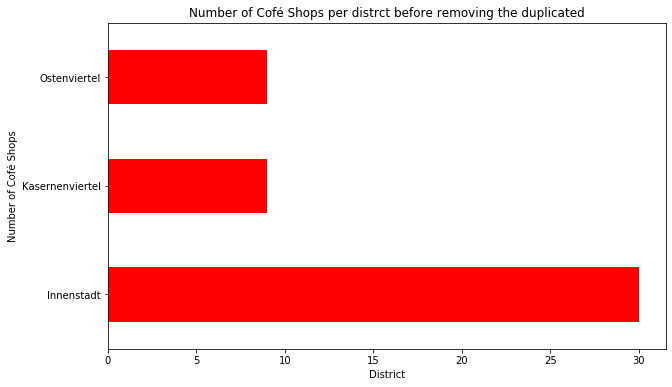

In [19]:
# step 2: plot data
df_t_bar.plot(kind='barh', figsize=(10, 6), color='r')

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Number of Cofé Shops') # add y-label to the plot
plt.title('Number of Cofé Shops per distrct before removing the duplicated') # add title to the plot


plt.savefig('/home/hector/Dropbox/courses/data-sci/08-App-ds-caps/cofe-bd.png')
plt.show()

In [21]:
# Checking for duplicates:
df_t.duplicated(subset=['name']).value_counts()

False    32
True     16
dtype: int64

In [22]:
df_t[['name','distance']];

In [23]:
# Sorting the dataframe by the distance from the Cofé shop to the center of the district
df_so = df_t.sort_values(by = ['distance']).reset_index(drop=True)
df_so.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,District
0,Café Scholz,Café,D.-Martin-Luther-Str. 2,49.016570,12.101370,"[{'label': 'display', 'lat': 49.01656975144709...",35,93047,DE,Regensburg,Bayern,Deutschland,"[D.-Martin-Luther-Str. 2 (Dachauplatz), 93047 ...",Dachauplatz,4b6c7b44f964a5209d3d2ce3,Innenstadt
1,Cafè Züchtig,Café,NaN,49.015835,12.106932,"[{'label': 'display', 'lat': 49.01583533449219...",64,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b8fd50ff964a520826433e3,Ostenviertel
2,Cafe Pernsteiner,None,NaN,49.016818,12.107558,"[{'label': 'display', 'lat': 49.01681838817746...",72,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b96a398f964a5209eda34e3,Ostenviertel
3,Cafe Fürstenhof,Café,NaN,49.016450,12.099384,"[{'label': 'display', 'lat': 49.01645, 'lng': ...",111,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4cd6d4ed122ba1435efb34a1,Innenstadt
4,190 GRAD CAFÉ BAR RÖSTEREI Rehorik,Café,Brixener Hof,49.016959,12.099510,"[{'label': 'display', 'lat': 49.016959, 'lng':...",114,93047,DE,Regensburg,Bayern,Deutschland,"[Brixener Hof, 93047 Regensburg]",NaN,54140ef8498e79de147ff0b6,Innenstadt


In [24]:
# Removinf the duplicates
df_so.drop_duplicates(subset=['name'], inplace = True)
df_so.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id,District
0,Café Scholz,Café,D.-Martin-Luther-Str. 2,49.016570,12.101370,"[{'label': 'display', 'lat': 49.01656975144709...",35,93047,DE,Regensburg,Bayern,Deutschland,"[D.-Martin-Luther-Str. 2 (Dachauplatz), 93047 ...",Dachauplatz,4b6c7b44f964a5209d3d2ce3,Innenstadt
1,Cafè Züchtig,Café,NaN,49.015835,12.106932,"[{'label': 'display', 'lat': 49.01583533449219...",64,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b8fd50ff964a520826433e3,Ostenviertel
2,Cafe Pernsteiner,None,NaN,49.016818,12.107558,"[{'label': 'display', 'lat': 49.01681838817746...",72,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4b96a398f964a5209eda34e3,Ostenviertel
3,Cafe Fürstenhof,Café,NaN,49.016450,12.099384,"[{'label': 'display', 'lat': 49.01645, 'lng': ...",111,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4cd6d4ed122ba1435efb34a1,Innenstadt
4,190 GRAD CAFÉ BAR RÖSTEREI Rehorik,Café,Brixener Hof,49.016959,12.099510,"[{'label': 'display', 'lat': 49.016959, 'lng':...",114,93047,DE,Regensburg,Bayern,Deutschland,"[Brixener Hof, 93047 Regensburg]",NaN,54140ef8498e79de147ff0b6,Innenstadt
5,Paul's Boutique Cafebar,Café,D.-Martin-Luther-Str. 2,49.017470,12.101546,"[{'label': 'display', 'lat': 49.01746994261155...",118,93047,DE,Regensburg,Bayern,Deutschland,"[D.-Martin-Luther-Str. 2, 93047 Regensburg]",NaN,4b96a479f964a520e7da34e3,Innenstadt
6,Museums-Café,Breakfast Spot,NaN,49.017926,12.102377,"[{'label': 'display', 'lat': 49.01792595705591...",192,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,4c53e717728920a1251dd981,Innenstadt
7,Cafe Samer,Hookah Bar,NaN,49.014793,12.105973,"[{'label': 'display', 'lat': 49.01479271829082...",196,NaN,DE,Regensburg,Bayern,Deutschland,[Regensburg],NaN,52a0e09a498e8e44e72394f6,Ostenviertel
8,Café Felix,Café,Fröhliche-Türken-Straße 6,49.016249,12.098075,"[{'label': 'display', 'lat': 49.01624877322131...",208,93047,DE,Regensburg,Bayern,Deutschland,"[Fröhliche-Türken-Straße 6, 93047 Regensburg]",NaN,4dcd78831850aa6414cccfb7,Innenstadt
9,Cafe Verschmitzt,Café,Hemauer Strasse 6,49.013245,12.102492,"[{'label': 'display', 'lat': 49.01324496519724...",229,93047,DE,Regensburg,Bayern,Deutschland,"[Hemauer Strasse 6, 93047 Regensburg]",NaN,5149a91b45b0a6d087bba29f,Kasernenviertel


### Obtaining the number of Cofé shops per district 

In [25]:
# Sorting again by district and counting the number of Cofé shops in each district 
df_so = df_so.sort_values(by = ['District']).reset_index(drop=True)
#df_so.groupby(['District']).count()

The number of Cofé shops pero district are:

In [26]:
df_so.groupby(['District'])['id'].count()

District
Innenstadt         22
Kasernenviertel     6
Ostenviertel        4
Name: id, dtype: int64

In [27]:
df_so_bar = df_so.groupby(['District'])['id'].count()
df_so_bar

District
Innenstadt         22
Kasernenviertel     6
Ostenviertel        4
Name: id, dtype: int64

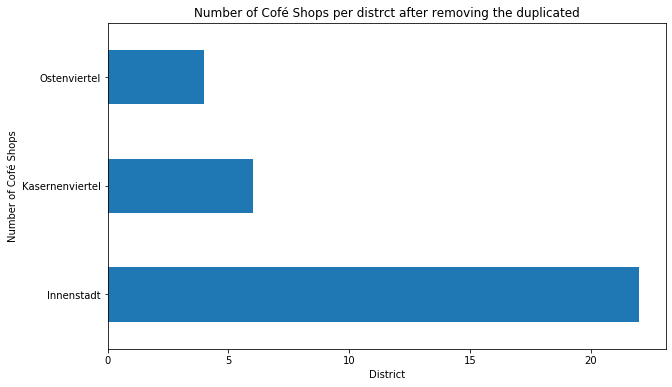

In [28]:
df_so_bar.plot(kind='barh', figsize=(10, 6))

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Number of Cofé Shops') # add y-label to the plot
plt.title('Number of Cofé Shops per distrct after removing the duplicated') # add title to the plot
plt.savefig('/home/hector/Dropbox/courses/data-sci/08-App-ds-caps/cofe-ad.png')
plt.show()

## Getting the number of tips for each Cofé shop
1. We split the dataframe per districts. 
2. We find the number of tips and the rating for each Cofé shop using the Foursquare API.
3. We use the number of tips as indicator of the number of people consuming Café on each street.


In [60]:
df_so_inn = df_so[df_so['District']=='Innenstadt'].reset_index(drop=True)
df_so_kas = df_so[df_so['District']=='Kasernenviertel'].reset_index(drop=True)
df_so_ost = df_so[df_so['District']=='Ostenviertel'].reset_index(drop=True)

In [61]:
for i in df_so_ost["id"]:
    url_id = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    result = requests.get(url_id).json()
    #print(result['response']['venue'].keys())
    #result['response']['venue']
    try:
        print('Id: {}, Venue: {}, Tips: {}, Rating: {}'.format(result['response']['venue']['id'],result['response']['venue']['name'],result['response']['venue']['tips']['count'],result['response']['venue']['rating']))
    except:
        print('Id:{}, Venue: {}'.format(result['response']['venue']['id'],result['response']['venue']['name']))
        print('This venue has not been rated yet.')

Id:52a0e09a498e8e44e72394f6, Venue: Cafe Samer
This venue has not been rated yet.
Id:4ca4c37bb0ff8cfa2a90c25e, Venue: Cafe Cafka
This venue has not been rated yet.
Id:4b96a398f964a5209eda34e3, Venue: Cafe Pernsteiner
This venue has not been rated yet.
Id:4b8fd50ff964a520826433e3, Venue: Cafè Züchtig
This venue has not been rated yet.
Id: 4b96a479f964a520e7da34e3, Venue: Paul's Boutique Cafebar, Tips: 5, Rating: 7.6


In [62]:
for i in df_so_inn["id"]:
    url_id_inn = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    result_inn = requests.get(url_id_inn).json()
    #print(result['response']['venue'].keys())
    #result['response']['venue']
    try:
        print('Id: {}, Venue: {}, Tips: {}, Rating: {}'.format(result_inn['response']['venue']['id'],result_inn['response']['venue']['name'],result_inn['response']['venue']['tips']['count'],result_inn['response']['venue']['rating']))
    except:
        print('Id:{}, Venue: {}'.format(result_inn['response']['venue']['id'],result_inn['response']['venue']['name']))
        print('This venue has not been rated yet.')

Id: 4b6c7b44f964a5209d3d2ce3, Venue: Café Scholz, Tips: 7, Rating: 6.9
Id:52b5f81711d2b9c003ece97a, Venue: Goliath Cafe+Bar
This venue has not been rated yet.
Id:4bdc3f4f63c5c9b6bae52a68, Venue: Café Segafredo
This venue has not been rated yet.
Id:501d6cc5e4b035a2203e09e7, Venue: Stelle - Eis Café Crêpes
This venue has not been rated yet.
Id: 4b9a84fcf964a5202fbd35e3, Venue: Café Picasso, Tips: 4, Rating: 5.7
Id:578b5216498e88772de91f38, Venue: Cafe Jolie
This venue has not been rated yet.
Id:4bd561b14e32d13a76bbc080, Venue: Café Punktgestalten.
This venue has not been rated yet.
Id:4c977b4e38dd8cfa47fbe362, Venue: Gelato'e Cafe
This venue has not been rated yet.
Id:53da8661498e1a43762f22b8, Venue: Barbarossa Cafe & Restaurant
This venue has not been rated yet.
Id: 4db813be93a04a7c3078118b, Venue: Café Lola, Tips: 11, Rating: 7.3
Id:5b0192addec1d6003901f668, Venue: Stella Eis Café Crêpes
This venue has not been rated yet.
Id: 5249626911d2b72efb1d7536, Venue: Stehcafé im Milchschwammerl

In [63]:
for i in df_so_kas["id"]:
    url_id_kas = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(i, CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
    result_kas = requests.get(url_id_kas).json()
    #print(result['response']['venue'].keys())
    #result['response']['venue']
    try:
        print('Id: {}, Venue: {}, Tips: {}, Rating: {}'.format(result_kas['response']['venue']['id'],result_kas['response']['venue']['name'],result_kas['response']['venue']['tips']['count'],result_kas['response']['venue']['rating']))
    except:
        print('Id:{}, Venue: {}'.format(result_kas['response']['venue']['id'],result_kas['response']['venue']['name']))
        print('This venue has not been rated yet.')

Id: 50ddc686e4b01e5ff2ea2972, Venue: ANNA, Tips: 9, Rating: 8.9
Id:55e0bafb498e6ef8d8f9b0e3, Venue: Beyoğlu Internet Cafe
This venue has not been rated yet.
Id:579cae05498e6e815c9eea94, Venue: Goliath Cafe Bar
This venue has not been rated yet.
Id:5149a91b45b0a6d087bba29f, Venue: Cafe Verschmitzt
This venue has not been rated yet.
Id:50d6d4ffe4b02e407e17f029, Venue: Bocello Cafe
This venue has not been rated yet.


New dataframe with the tips and the ratings for each Cofé shop

In [29]:
data_tips = [['4b6c7b44f964a5209d3d2ce3','Café Scholz',7,6.9,'Innenstadt'],['4dcd78831850aa6414cccfb7','Café Felix',2,7.0,'Innenstadt'],
             ['4c53e717728920a1251dd981','Museums-Café',2,7.5,'Innenstadt'],['4b96a479f964a520e7da34e3',"Paul's Boutique Cafebar",5,7.6,'Innenstadt'],
             ['4cc2986138aaa09305590762','Café Rinaldi',8,7.0,'Innenstadt'],['54140ef8498e79de147ff0b6','190 GRAD CAFÉ BAR RÖSTEREI Rehorik',7,8.5,'Innenstadt'],
             ['4db813be93a04a7c3078118b','Café Lola',11,7.3,'Innenstadt'],['4b9a84fcf964a5202fbd35e3','Café Picasso',4,5.7,'Innenstadt'],
             ['5249626911d2b72efb1d7536','Stehcafé im Milchschwammerl',4,7.0,'Kasernenviertel'],['50ddc686e4b01e5ff2ea2972','ANNA',9,8.9,'Kasernenviertel'] ]

df_tips = pd.DataFrame(data_tips, columns = ['id', 'venue','tips','rating','district']) 
df_tips = df_tips.sort_values(by = ['tips'], ascending=False).reset_index(drop=True)
df_tips

,id,venue,tips,rating,district
0,4db813be93a04a7c3078118b,Café Lola,11,7.3,Innenstadt
1,50ddc686e4b01e5ff2ea2972,ANNA,9,8.9,Kasernenviertel
2,4cc2986138aaa09305590762,Café Rinaldi,8,7.0,Innenstadt
3,4b6c7b44f964a5209d3d2ce3,Café Scholz,7,6.9,Innenstadt
4,54140ef8498e79de147ff0b6,190 GRAD CAFÉ BAR RÖSTEREI Rehorik,7,8.5,Innenstadt
5,4b96a479f964a520e7da34e3,Paul's Boutique Cafebar,5,7.6,Innenstadt
6,4b9a84fcf964a5202fbd35e3,Café Picasso,4,5.7,Innenstadt
7,5249626911d2b72efb1d7536,Stehcafé im Milchschwammerl,4,7.0,Kasernenviertel
8,4dcd78831850aa6414cccfb7,Café Felix,2,7.0,Innenstadt
9,4c53e717728920a1251dd981,Museums-Café,2,7.5,Innenstadt


In [30]:
df_tips[["venue",'tips','district']]

,venue,tips,district
0,Café Lola,11,Innenstadt
1,ANNA,9,Kasernenviertel
2,Café Rinaldi,8,Innenstadt
3,Café Scholz,7,Innenstadt
4,190 GRAD CAFÉ BAR RÖSTEREI Rehorik,7,Innenstadt
5,Paul's Boutique Cafebar,5,Innenstadt
6,Café Picasso,4,Innenstadt
7,Stehcafé im Milchschwammerl,4,Kasernenviertel
8,Café Felix,2,Innenstadt
9,Museums-Café,2,Innenstadt


In [31]:
df_tips.groupby(['district'])['rating'].mean()

district
Innenstadt         7.1875
Kasernenviertel    7.9500
Name: rating, dtype: float64

In [42]:
df_tips.groupby(['district'])['tips'].count()

district
Innenstadt         8
Kasernenviertel    2
Name: tips, dtype: int64

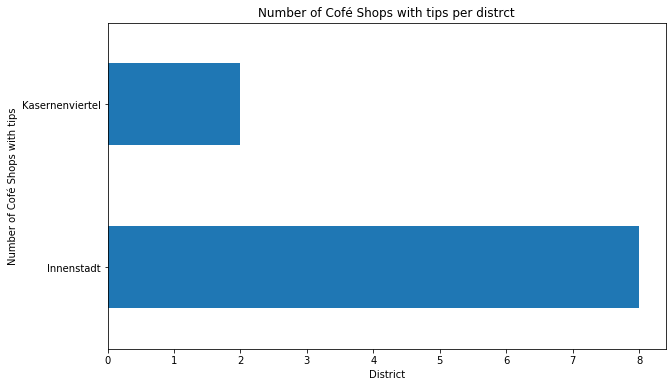

In [46]:
#df_tips_bar = df_tips.groupby(['district'])['tips'].mean()
#df_tips_bar = df_tips[['district','tips']]
df_tips_bar = df_tips.groupby(['district'])['tips'].count()

df_tips_bar.plot(kind='barh', figsize=(10, 6))

plt.xlabel('District') # add to x-label to the plot
plt.ylabel('Number of Cofé Shops with tips') # add y-label to the plot
plt.title('Number of Cofé Shops with tips per distrct') # add title to the plot
plt.savefig('/home/hector/Dropbox/courses/data-sci/08-App-ds-caps/tips-pd.png')
plt.show()

## Results:
Here we present the result for the data analysis for the Cofé shops in the city of Regensburg. 
1. In the first part, we found that the distribution of the Cofé shop over the city is of the form:

| District                              | Cofé shops |
|---------------------------------------|------------|
| Großprüfening-Dechbetten-Königswiesen |    0       |
| Innenstadt                            |   22       |
| Kasernenviertel                       |    6       |
| Ostenviertel                          |    4       |
| Westenviertel                         |    0       |
| Brandlberg-Keilberg                   |    0       |
| Galgenberg                            |    0       |


This clearly show which that the worst places to open a Cofé shop are:
* Großprüfening-Dechbetten-Königswiesen
* Westenviertel                      
* Brandlberg-Keilberg                  
* Galgenberg 

And the potential districts to open the Cofé shops clearly are: 
* Innenstadt         
* Kasernenviertel    
* Ostenviertel       

Is important to note that these three districts are the ones near of the city center and the University of Regensburg. 

2. In the second part of the analysis we found that there are 8 Cofé shops with ratings and tips in the Innerstadt district in contrast to only 2 found in the Kasernenviertel district and 0 for the Ostenviertel district. The result for the number of Cofé shops per district including the mean rating per district are presented in the following table.

| District        | No. Cofé shops with tips | Mean rating |
|-----------------|--------------------------|-------------|
| Innenstadt      |               8          |  7.1875     |
| Kasernenviertel |               2          |  7.95       |
| Ostenviertel    |               0          |  0.0        |           

## Discussion
As we mention before, Regensburg is a small tourist and academic city. For this reason the number of venues is mostly reduced to restaurants and Cofé shops. For this reason is important to know where is the district with more clients. Due to this is important to know that the characteristics of each district are very different. As we saw in the analysis some of the do not contain any establishments of this kind. Also we can notice from the second part of the analysis that even the Kasernenviertel and Innerstadt districts have almost the same mean for the rating, Innerstadt has a higher number of Cofé shops and number of tips. This means that the number of persons in this district is higher than in the Kasernenviertel district. As conclusion the Innerstadt district is the best option to open a Cofé shop. As final result is that the Innerstadt district is the the best option the Cofé shop.  


## Conclusions
In this project we analyzed which district in the city of Regensburg is the best to open a Cofé shop. First we analyzed the distribution of all the Cofé shops across the city using the Foursquare API. Here we found that there are mainly three important districts to these kind of establishments, the Innenstadt district, the Kasernenviertel district, and the Ostenviertel district. Secondly, with the previous information and adding the tips and ratings as a measure of the flow of people for each Cofé shop we were able to determine which was the best candidate zone for the new Cofé shop. 